In [441]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay, accuracy_score, classification_report, confusion_matrix, precision_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import RidgeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.tree import plot_tree

In [442]:
def data_results(testing_classes, testing_inputs, alg_class):
    cm_display = ConfusionMatrixDisplay(
        confusion_matrix=confusion_matrix(testing_classes, alg_class.predict(testing_inputs))
    )

    cm_display.plot()
    plt.xticks([0, 1], ["No", "Yes"])
    plt.yticks([0, 1], ["No", "Yes"])
    plt.xlabel('Predicted Entry')
    plt.ylabel('Actual Entry')
    plt.show()

    print(classification_report(testing_classes, alg_class.predict(testing_inputs)))

Fitting 5 folds for each of 144 candidates, totalling 720 fits
Feature: rank, Importance: 0.12635467001981376
Feature: won, Importance: 0.0
Feature: Cumulative PER, Importance: 0.460764350779915
Feature: Cumulative Win Rate, Importance: 0.4128809792002711
2
    tmID   predict  predictNormalized
1    ATL  0.714286                  1
12   CHI  0.428571                  0
23   CON  1.000000                  1
52   IND  1.000000                  1
85   NYL  1.000000                  1
141  WAS  0.428571                  0
    tmID   predict  predictNormalized
33   DET  0.120000                  0
62   LAS  0.714286                  1
75   MIN  0.428571                  0
98   PHO  1.000000                  1
118  SAS  1.000000                  1
128  SEA  0.857143                  1


c:\Users\JoaoCoutinho\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\ma\core.py:2881: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,
C:\Users\JoaoCoutinho\AppData\Local\Temp\ipykernel_22404\2616809764.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teams_test['predict'] = probs
C:\Users\JoaoCoutinho\AppData\Local\Temp\ipykernel_22404\2616809764.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teams_test['predictNormalized'] 

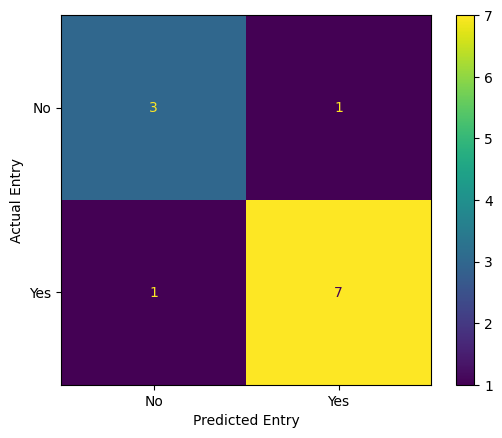

              precision    recall  f1-score   support

           0       0.75      0.75      0.75         4
           1       0.88      0.88      0.88         8

    accuracy                           0.83        12
   macro avg       0.81      0.81      0.81        12
weighted avg       0.83      0.83      0.83        12



In [ ]:
df_teams = pd.read_csv('dataset/processed/teams_test.csv')
df_teams = df_teams.sort_values(by=['franchID', 'year'])
df_teams['playoffNextYear'] = df_teams['playoff'].shift(-1)
df_teams.loc[df_teams['franchID'] != df_teams['franchID'].shift(-1), 'playoffNextYear'] = None
df_teams.dropna(subset=['playoffNextYear'], inplace=True)
label_encoder_tmID = LabelEncoder()
label_encoder_playoff = LabelEncoder()
label_encoder_playoffNextYear = LabelEncoder()

df_teams['playoff'] = label_encoder_playoff.fit_transform(df_teams['playoff'])
df_teams['playoffNextYear'] = label_encoder_playoffNextYear.fit_transform(df_teams['playoffNextYear'])
features = ['rank', 'won', 'Cumulative PER', 'Cumulative Win Rate'] # attend?

df_teams_train = df_teams[df_teams['year'] <= 8]
df_teams_test = df_teams[df_teams['year'].isin([9])]

training_inputs = df_teams_train[features]
training_classes = df_teams_train['playoffNextYear']
testing_inputs = df_teams_test[features]
testing_classes = df_teams_test['playoffNextYear']

dt_class = DecisionTreeClassifier(random_state=42)

param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 2, 3, 4, 5, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(
    estimator=dt_class,
    param_grid=param_grid,
    scoring='accuracy',
    cv=5,
    verbose=1,
    n_jobs=-1
)

grid_search.fit(training_inputs, training_classes)

best_model = grid_search.best_estimator_

importance = best_model.feature_importances_
for feature, imp in zip(features, importance):
    print(f"Feature: {feature}, Importance: {imp}")

probs = [pred[1] for pred in best_model.predict_proba(testing_inputs)]
df_teams_test['predict'] = probs
df_teams_test['predictNormalized'] = (df_teams_test.groupby('confID')['predict'].rank(method='first', ascending=False) <= 4).astype(int)
df_teams_test['result'] = abs(df_teams_test['predictNormalized'] - df_teams_test['playoffNextYear'])
print(df_teams_test['result'].sum())
print(df_teams_test.loc[df_teams_test['confID']=="EA", ['tmID', 'predict', 'predictNormalized']])
print(df_teams_test.loc[df_teams_test['confID']=="WE", ['tmID', 'predict', 'predictNormalized']])
#print(tmID_label_mapping)

data_results(testing_classes, testing_inputs, best_model)

# plot_tree(dt_class, feature_names=features, filled=True)

In [444]:
'''rf_class = RandomForestClassifier(n_estimators=100)
rf_class.fit(training_inputs, training_classes)

param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None],
}

grid_search = GridSearchCV(estimator=rf_class, param_grid=param_grid, scoring='accuracy', cv=5, n_jobs=-1)
grid_search.fit(training_inputs, training_classes)
best_model = grid_search.best_estimator_
best_model.predict(testing_inputs)

best_model.score(testing_inputs, testing_classes)

probs = [pred[1] for pred in best_model.predict_proba(testing_inputs)]
df_teams_test['predict'] = probs
df_teams_test['result'] = abs(df_teams_test['predict'] - df_teams_test['playoffNextYear'])
print(df_teams_test['result'].sum())
accuracy_score(testing_classes, best_model.predict(testing_inputs))

data_results(testing_classes, testing_inputs, best_model)'''

"rf_class = RandomForestClassifier(n_estimators=100)\nrf_class.fit(training_inputs, training_classes)\n\nparam_grid = {\n    'n_estimators': [100, 200],\n    'max_depth': [10, 20, None],\n    'min_samples_split': [2, 5, 10],\n    'min_samples_leaf': [1, 2, 4],\n    'max_features': ['sqrt', 'log2', None],\n}\n\ngrid_search = GridSearchCV(estimator=rf_class, param_grid=param_grid, scoring='accuracy', cv=5, n_jobs=-1)\ngrid_search.fit(training_inputs, training_classes)\nbest_model = grid_search.best_estimator_\nbest_model.predict(testing_inputs)\n\nbest_model.score(testing_inputs, testing_classes)\n\nprobs = [pred[1] for pred in best_model.predict_proba(testing_inputs)]\ndf_teams_test['predict'] = probs\ndf_teams_test['result'] = abs(df_teams_test['predict'] - df_teams_test['playoffNextYear'])\nprint(df_teams_test['result'].sum())\naccuracy_score(testing_classes, best_model.predict(testing_inputs))\n\ndata_results(testing_classes, testing_inputs, best_model)"

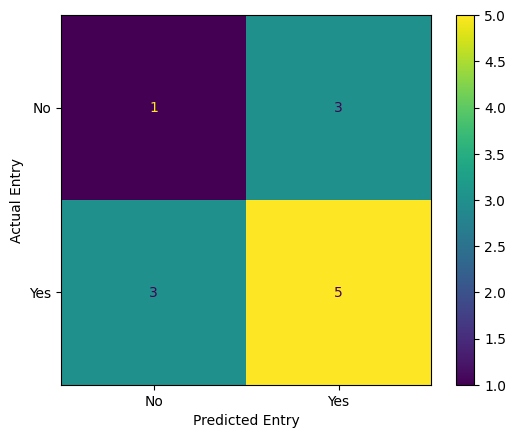

              precision    recall  f1-score   support

           0       0.25      0.25      0.25         4
           1       0.62      0.62      0.62         8

    accuracy                           0.50        12
   macro avg       0.44      0.44      0.44        12
weighted avg       0.50      0.50      0.50        12



In [445]:
nb_class = GaussianNB()
nb_class.fit(training_inputs, training_classes)

nb_class.score(testing_inputs, testing_classes)

accuracy_score(testing_classes, nb_class.predict(testing_inputs))

data_results(testing_classes, testing_inputs, nb_class)

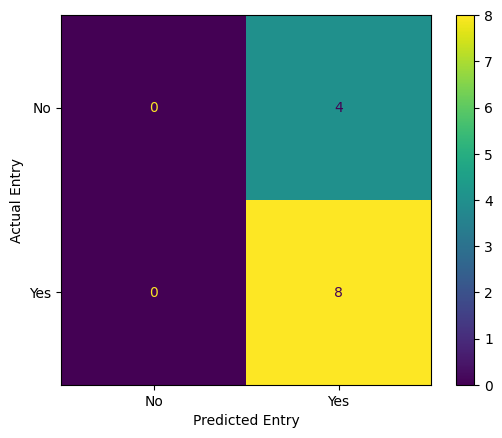

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         4
           1       0.67      1.00      0.80         8

    accuracy                           0.67        12
   macro avg       0.33      0.50      0.40        12
weighted avg       0.44      0.67      0.53        12



c:\Users\JoaoCoutinho\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\JoaoCoutinho\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\JoaoCoutinho\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  

In [446]:
svm_class = SVC(kernel='rbf', probability=True)

param_grid = {
    'C': [0.1, 1, 10, 100],
    'kernel': ['rbf', 'linear'],
    'gamma': [1, 0.1, 0.01, 0.001],
}

grid_search = GridSearchCV(estimator=svm_class, param_grid=param_grid, scoring='accuracy', cv=5, n_jobs=-1)
grid_search.fit(training_inputs, training_classes)
best_model = grid_search.best_estimator_
accuracy_score(testing_classes, best_model.predict(testing_inputs))

data_results(testing_classes, testing_inputs, best_model)

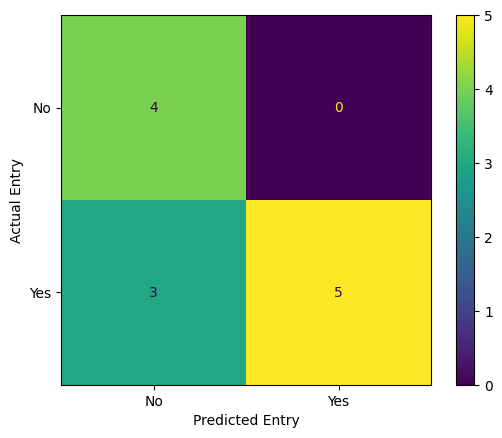

              precision    recall  f1-score   support

           0       0.57      1.00      0.73         4
           1       1.00      0.62      0.77         8

    accuracy                           0.75        12
   macro avg       0.79      0.81      0.75        12
weighted avg       0.86      0.75      0.76        12



In [447]:
knn_class = KNeighborsClassifier(n_neighbors=13, algorithm='auto', metric='minkowski', p=1, weights='distance')

knn_class.fit(training_inputs, training_classes)

knn_class.score(testing_inputs, testing_classes)

accuracy_score(testing_classes, knn_class.predict(testing_inputs))

data_results(testing_classes, testing_inputs, knn_class)

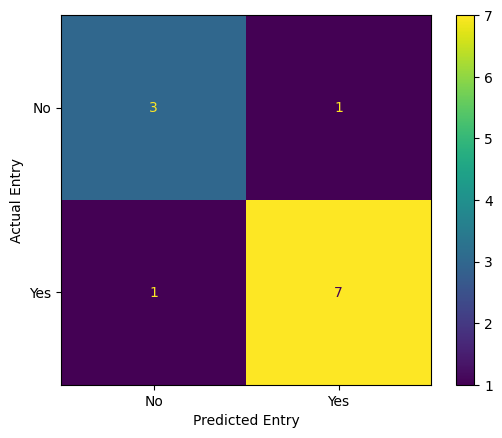

              precision    recall  f1-score   support

           0       0.75      0.75      0.75         4
           1       0.88      0.88      0.88         8

    accuracy                           0.83        12
   macro avg       0.81      0.81      0.81        12
weighted avg       0.83      0.83      0.83        12



In [448]:
ab_class = AdaBoostClassifier(n_estimators=100, algorithm="SAMME", random_state=42)

ab_class.fit(training_inputs, training_classes)
ab_class.score(testing_inputs, testing_classes)

accuracy_score(testing_classes, ab_class.predict(testing_inputs))

data_results(testing_classes, testing_inputs, ab_class)